# Feature Engineering Explanation

This document explains the features engineered for electricity spot price forecasting, along with the rationale behind each feature.

## Time-based Features

1. `hour`: Hour of the day (0-23)
   - Rationale: Captures daily patterns in electricity demand and price.

2. `day_of_week`: Day of the week (0-6, where 0 is Monday)
   - Rationale: Captures weekly patterns in electricity consumption and generation.

3. `is_weekend`: Binary indicator for weekends
   - Rationale: Weekends often have different electricity usage patterns compared to weekdays.

4. `month`: Month of the year (1-12)
   - Rationale: Captures seasonal patterns in electricity demand and generation.

5. `year`: Year
   - Rationale: Allows the model to capture long-term trends and yearly variations.

6. `season`: Categorical variable (Winter, Spring, Summer, Fall)
   - Rationale: Groups months into seasons, which can have distinct electricity usage patterns.

## Lagged Features

7. `price_lag_1h`: Spot price from 1 hour ago
8. `price_lag_24h`: Spot price from 24 hours ago
9. `price_lag_168h`: Spot price from 168 hours (1 week) ago
   - Rationale: Capture recent price history and periodic patterns (daily, weekly).

## Rolling Statistics

10. `price_rolling_mean_24h`: 24-hour rolling mean of spot price
11. `price_rolling_std_24h`: 24-hour rolling standard deviation of spot price
12. `price_rolling_mean_7d`: 7-day rolling mean of spot price
13. `price_rolling_std_7d`: 7-day rolling standard deviation of spot price
    - Rationale: Capture short-term and medium-term price trends and volatility.

14-21. Similar rolling statistics for demand and production
    - Rationale: Capture trends and volatility in demand and production, which influence price.

## Demand and Production Features

22. `demand_production_ratio`: Ratio of demand to production
    - Rationale: Indicates supply-demand balance, a key driver of price.

23. `demand_lag_24h`: Demand from 24 hours ago
24. `production_lag_24h`: Production from 24 hours ago
    - Rationale: Capture recent demand and production history.

## Volatility Features

25. `daily_price_range`: Daily range of spot price (max - min)
26. `price_change_1h`: Price change from previous hour
    - Rationale: Capture price volatility and recent price movements.

27. `daily_demand_range`: Daily range of demand
28. `daily_production_range`: Daily range of production
    - Rationale: Capture volatility in demand and production.

## Cyclical Features

29-32. Sine and cosine transformations of hour and month
    - Rationale: Capture cyclical patterns in a way that's easier for models to learn.

## Interaction Features

33. `hour_day_interaction`: Interaction between hour and day of week
34. `month_hour_interaction`: Interaction between month and hour
    - Rationale: Capture complex temporal relationships.

## Statistical Features

35-37. Exponential weighted means (EWM) for price, demand, and production
    - Rationale: Capture trends while giving more weight to recent observations.

## Anomaly Indicators

38. Binary indicators for anomalies in price - Rationale: Flag unusual events that might influence price.

## Transformed Features

39. `price_boxcox`: Box-Cox transformation of spot price
    - Rationale: Handle non-linearity and potentially improve model performance.


,volume_demand,volume_production,spot_price,day_of_week,is_weekend,month,year,season,price_lag_1d,price_lag_7d,price_lag_30d,price_rolling_mean_7d,price_rolling_std_7d,price_rolling_mean_30d,price_rolling_std_30d,demand_production_ratio,demand_lag_1d,production_lag_1d,demand_rolling_mean_7d,demand_rolling_std_7d,demand_rolling_mean_30d,demand_rolling_std_30d,production_rolling_mean_7d,production_rolling_std_7d,production_rolling_mean_30d,production_rolling_std_30d,price_change_1d,month_sin,month_cos,price_ewm_alpha_0.5,demand_ewm_alpha_0.5,production_ewm_alpha_0.5,price_anomaly,price_boxcox
datetime_utc,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-30 00:00:00+00:00,4599.791667,5187.291667,15.345417,5,1,1,2016,Winter,16.175417,23.850000,16.390000,18.487500,3.319242,26.132903,9.739202,0.886742,4700.625000,5592.875000,4733.839286,116.882114,5241.088889,438.167965,6671.726190,1167.176936,8276.529167,1146.855153,-0.830000,0.0,1.000000,16.220023,4660.060204,5675.113419,0,1.479731
2016-01-31 00:00:00+00:00,4589.958333,5701.583333,16.520833,6,1,1,2016,Winter,15.345417,22.198750,16.622500,17.676369,2.932378,26.129514,9.742643,0.805032,4599.791667,5187.291667,4691.803571,106.215536,5249.722222,421.865362,6308.142857,975.465852,8190.968056,1239.489392,1.175417,0.0,1.000000,16.370428,4625.009269,5688.348376,0,1.495869
2016-02-01 00:00:00+00:00,4990.541667,7124.791667,18.585417,0,0,2,2016,Winter,16.520833,24.057500,15.377500,16.894643,1.112274,26.236444,9.637602,0.700447,4589.958333,5701.583333,4706.303571,139.379741,5261.219444,409.348374,6179.892857,744.067351,8182.177778,1246.293037,2.064583,0.5,0.866025,17.477922,4807.775468,6406.570021,0,1.520580
2016-02-02 00:00:00+00:00,4856.541667,6394.375000,16.956250,1,0,2,2016,Winter,18.585417,18.105000,16.045000,16.730536,0.980921,26.266819,9.605758,0.759502,4990.541667,7124.791667,4726.523810,150.661942,5259.643056,410.860383,6093.755952,664.288345,8133.090278,1287.456165,-1.629167,0.5,0.866025,17.217086,4832.158567,6400.472511,0,1.501437
2016-02-03 00:00:00+00:00,4928.916667,7136.416667,17.781250,2,0,2,2016,Winter,16.956250,16.699583,18.644167,16.885060,1.057445,26.238056,9.630630,0.690671,4856.541667,6394.375000,4772.351190,157.288309,5245.075000,414.691058,6249.500000,770.579994,8071.573611,1289.588025,0.825000,0.5,0.866025,17.499168,4880.537617,6768.444589,0,1.511446


,volume_demand,volume_production,spot_price,day_of_week,is_weekend,month,year,price_lag_1d,price_lag_7d,price_lag_30d,price_rolling_mean_7d,price_rolling_std_7d,price_rolling_mean_30d,price_rolling_std_30d,demand_production_ratio,demand_lag_1d,production_lag_1d,demand_rolling_mean_7d,demand_rolling_std_7d,demand_rolling_mean_30d,demand_rolling_std_30d,production_rolling_mean_7d,production_rolling_std_7d,production_rolling_mean_30d,production_rolling_std_30d,price_change_1d,month_sin,month_cos,price_ewm_alpha_0.5,demand_ewm_alpha_0.5,production_ewm_alpha_0.5,price_anomaly,price_boxcox
count,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,958.000000,9.580000e+02,9.580000e+02,958.000000,958.000000,958.000000,958.000000,958.000000
mean,3987.961298,5783.919757,31.042867,2.998956,0.286013,6.215031,2016.915449,31.006662,30.794482,30.204984,30.933970,1.827869,30.636412,2.820066,0.716804,3989.445945,5784.648923,3991.890131,165.444535,4014.883160,226.508149,5787.492658,731.733010,5825.633274,869.669144,0.036205,8.757761e-02,-6.960012e-02,31.006522,3989.297238,5784.855968,0.003132,1.605059
std,726.343622,1598.075883,9.030689,2.001828,0.452131,3.240887,0.782616,9.020679,8.872781,8.308742,8.724455,1.399088,8.018250,1.727693,0.131396,726.345209,1597.828906,707.694304,68.287269,701.891526,83.362261,1421.314016,299.007522,1362.014776,247.678549,2.443376,6.981108e-01,7.079259e-01,8.850723,714.447756,1484.596497,0.055902,0.044627
min,2831.458333,2117.416667,14.692083,0.000000,0.000000,1.000000,2016.000000,14.692083,14.692083,14.692083,16.730536,0.157490,18.330611,0.495056,0.513432,2831.458333,2117.416667,3000.047619,32.038975,3075.987500,95.952004,3475.875000,124.811602,3800.756944,363.198575,-14.582083,-1.000000e+00,-1.000000e+00,15.585391,2904.918464,2655.195757,0.000000,1.469978
25%,3351.406250,4535.625000,24.149334,1.000000,0.000000,3.000000,2016.000000,24.142917,24.044896,23.944375,23.835640,0.932246,23.906059,1.616253,0.622977,3351.541667,4535.625000,3322.897321,118.530817,3331.415625,148.768713,4445.235119,508.970723,4327.903819,686.895464,-0.838750,-5.000000e-01,-8.660254e-01,23.973956,3335.540700,4507.028659,0.000000,1.571137
50%,3858.750000,5597.166667,29.397292,3.000000,0.000000,6.000000,2017.000000,29.380417,29.310417,29.102500,29.906429,1.417648,29.804882,2.207659,0.689912,3858.958333,5597.166667,3891.470238,146.720489,3910.928472,224.992927,5799.532738,707.307131,5938.935417,866.161698,-0.094792,1.224647e-16,-1.836970e-16,29.602906,3887.217009,5695.940210,0.000000,1.605339
75%,4607.447917,7098.979167,35.048125,5.000000,1.000000,9.000000,2018.000000,35.014792,34.671875,33.555104,34.507827,2.257352,33.452358,3.515533,0.772679,4609.270833,7098.979167,4667.040179,190.956259,4686.241319,295.196142,6889.882440,905.757000,6875.105118,1043.728992,0.819479,8.660254e-01,5.000000e-01,34.632019,4632.839645,6964.738945,0.000000,1.633378
max,6060.833333,9057.500000,58.678333,6.000000,1.000000,12.000000,2018.000000,58.678333,58.678333,54.087083,57.675952,7.751715,52.924125,10.347866,1.403676,6060.833333,9057.500000,5656.851190,499.858289,5321.550000,454.080119,8662.720238,1688.088989,8376.275000,1435.988541,14.947083,1.000000e+00,1.000000e+00,58.163433,5894.698037,8842.015059,1.000000,1.703211


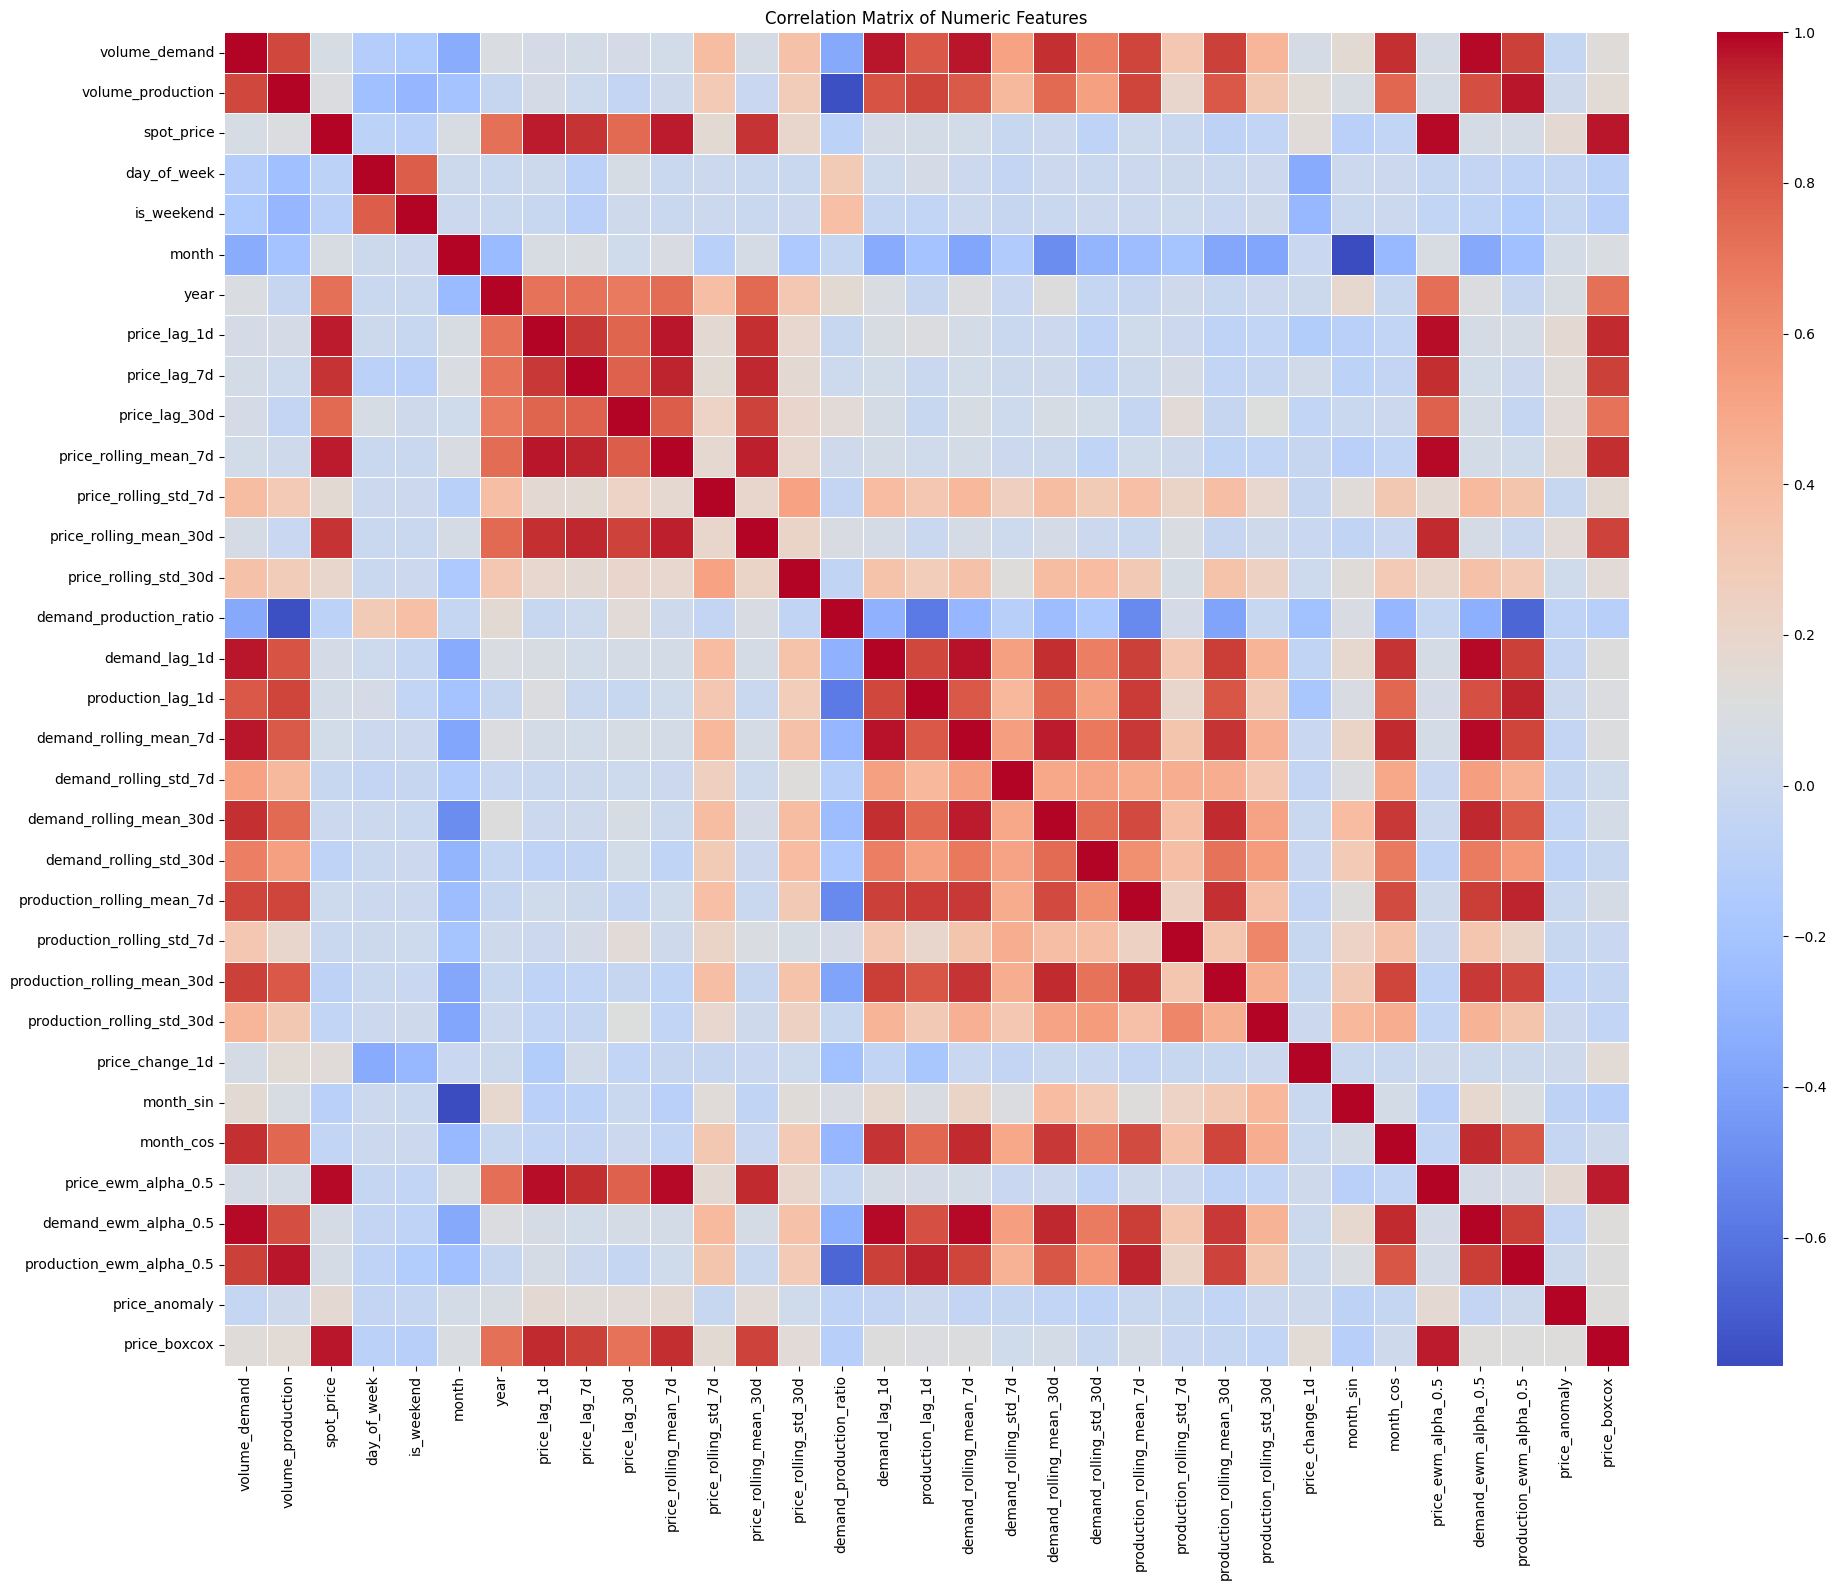


Value counts for season:


,count
season,
Spring,273
Summer,259
Winter,242
Fall,184


In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
from scipy.stats import boxcox
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv("Datasets/data_NO2.csv", sep=";", parse_dates=["datetime_utc"])

# Set datetime_utc as index and resample to daily frequency
df.set_index("datetime_utc", inplace=True)
df = df.resample('D').mean()

# Time-based features
df["day_of_week"] = df.index.dayofweek
df["is_weekend"] = df["day_of_week"].isin([5, 6]).astype(int)
df["month"] = df.index.month
df["year"] = df.index.year
df["season"] = pd.cut(
    df["month"], bins=[0, 3, 6, 9, 12], labels=["Winter", "Spring", "Summer", "Fall"]
)

# Lagged features
df["price_lag_1d"] = df["spot_price"].shift(1)
df["price_lag_7d"] = df["spot_price"].shift(7)
df["price_lag_30d"] = df["spot_price"].shift(30)

# Rolling statistics for price
df["price_rolling_mean_7d"] = df["spot_price"].rolling(window=7).mean()
df["price_rolling_std_7d"] = df["spot_price"].rolling(window=7).std()
df["price_rolling_mean_30d"] = df["spot_price"].rolling(window=30).mean()
df["price_rolling_std_30d"] = df["spot_price"].rolling(window=30).std()

# Demand and Production features
df["demand_production_ratio"] = df["volume_demand"] / df["volume_production"]
df["demand_lag_1d"] = df["volume_demand"].shift(1)
df["production_lag_1d"] = df["volume_production"].shift(1)

# Rolling statistics for demand and production
df["demand_rolling_mean_7d"] = df["volume_demand"].rolling(window=7).mean()
df["demand_rolling_std_7d"] = df["volume_demand"].rolling(window=7).std()
df["demand_rolling_mean_30d"] = df["volume_demand"].rolling(window=30).mean()
df["demand_rolling_std_30d"] = df["volume_demand"].rolling(window=30).std()

df["production_rolling_mean_7d"] = df["volume_production"].rolling(window=7).mean()
df["production_rolling_std_7d"] = df["volume_production"].rolling(window=7).std()
df["production_rolling_mean_30d"] = df["volume_production"].rolling(window=30).mean()
df["production_rolling_std_30d"] = df["volume_production"].rolling(window=30).std()

df["price_change_1d"] = df["spot_price"].diff()

# Cyclical features
df["month_sin"] = np.sin((df["month"] - 1) * (2 * np.pi / 12))
df["month_cos"] = np.cos((df["month"] - 1) * (2 * np.pi / 12))

# Statistical features
df["price_ewm_alpha_0.5"] = df["spot_price"].ewm(alpha=0.5).mean()
df["demand_ewm_alpha_0.5"] = df["volume_demand"].ewm(alpha=0.5).mean()
df["production_ewm_alpha_0.5"] = df["volume_production"].ewm(alpha=0.5).mean()

# Anomaly indicators
price_mean, price_std = df["spot_price"].mean(), df["spot_price"].std()
demand_mean, demand_std = df["volume_demand"].mean(), df["volume_demand"].std()
production_mean, production_std = df["volume_production"].mean(), df["volume_production"].std()

df["price_anomaly"] = ((df["spot_price"] - price_mean).abs() > 3 * price_std).astype(int)

# Box-Cox transformation of price (to handle non-linearity)
df["price_boxcox"], _ = boxcox(df["spot_price"] + 1)  # Adding 1 to handle zero values

# Drop rows with NaN values created by lagging/rolling operations
df.dropna(inplace=True)

# Display the first few rows of the dataset in a prettier format
display(HTML(df.head().to_html(classes='table table-striped table-hover')))

# Show summary statistics
display(HTML(df.describe().to_html(classes='table table-striped table-hover')))

# Correlation matrix and heatmap for numeric columns only
numeric_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(20, 16))
sns.heatmap(numeric_df.corr(), annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.show()

# For categorical columns, show value counts
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
for col in categorical_columns:
    print(f"\nValue counts for {col}:")
    display(HTML(df[col].value_counts().to_frame().to_html(classes='table table-striped table-hover')))

# Save the engineered features dataset
df.to_csv('Datasets/engineered_features_daily.csv')